In [2]:
import pandas as pd
import numpy as np

# Loading data

In [3]:
data = pd.read_csv('./housing.csv')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
import matplotlib.pyplot as plt

# Visuals

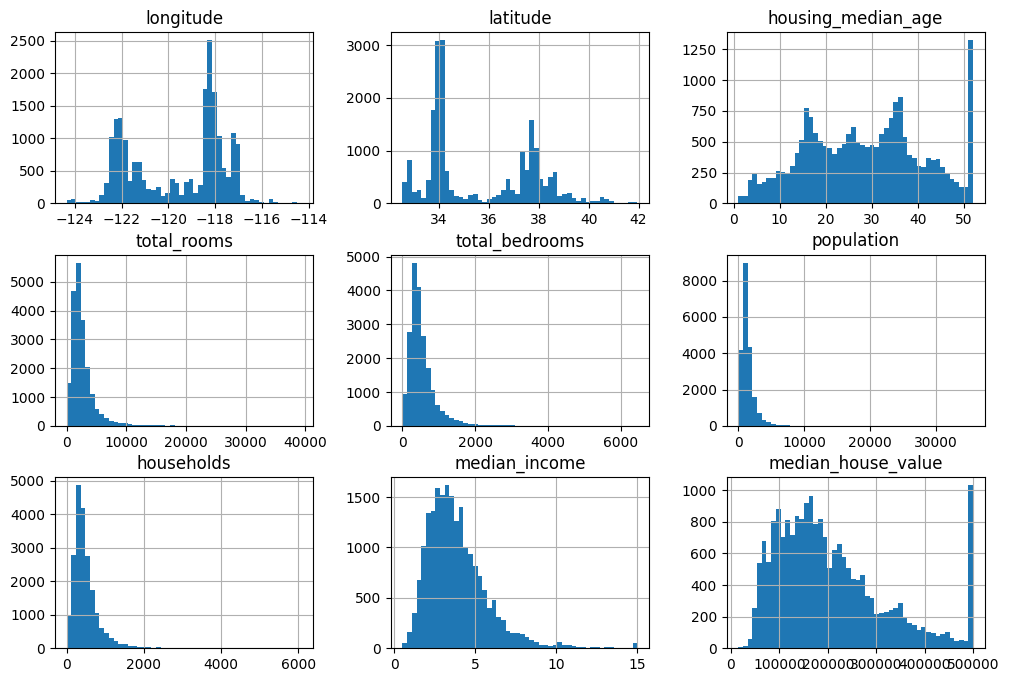

In [6]:
data.hist(bins=50 ,figsize=(12,8))
plt.show()

# Splitting

In [7]:
data["income_cat"] = pd.cut(data["median_income"],
bins=[0., 1.5, 3.0, 4.5, 6.,float('inf')],
labels=[1, 2, 3, 4, 5])

In [8]:
from sklearn.model_selection import StratifiedShuffleSplit
import sklearn

sklearn.set_config(display="diagram")

In [9]:
data.columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'median_house_value', 'ocean_proximity', 'income_cat'],
      dtype='object')

In [10]:
splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=69)

strat_splits = []

for train_index,test_index in splitter.split(data,data['income_cat']):
    strat_train_set_n = data.loc[train_index]
    strat_test_set_n = data.loc[test_index]
    strat_splits.append([strat_train_set_n, strat_test_set_n])

In [11]:
strat_train_set, strat_test_set = strat_splits[0]

In [12]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [13]:
housing = strat_train_set.copy()

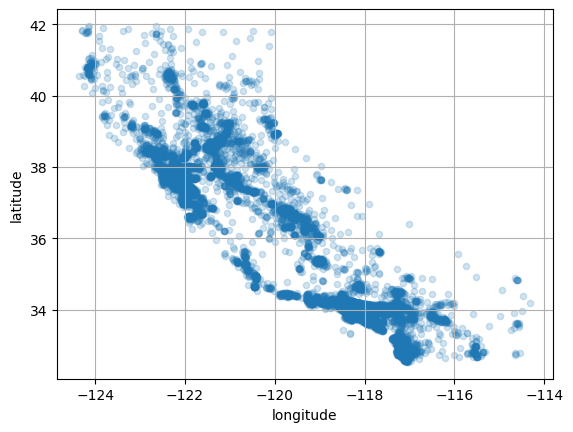

In [14]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True , alpha =0.2)
plt.show()

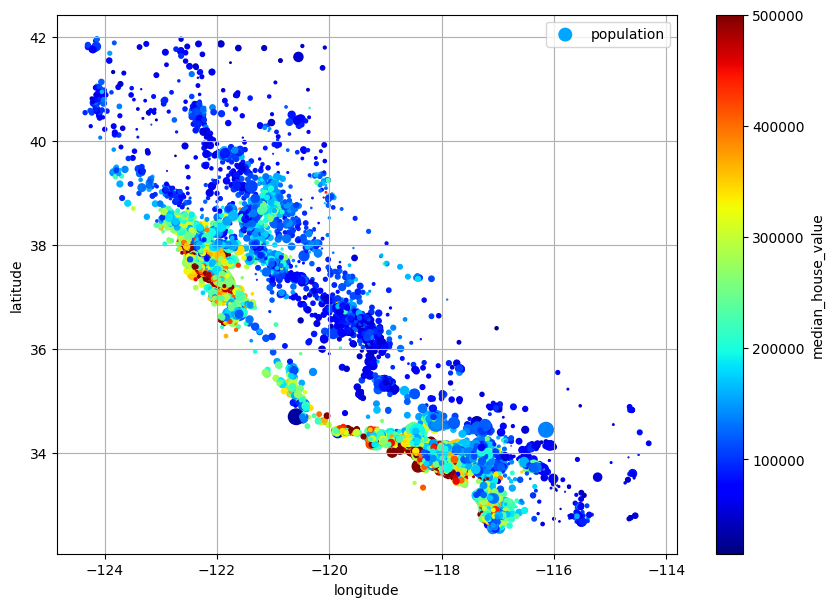

In [15]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True,
s=housing["population"] / 100, label="population",
c="median_house_value", cmap="jet", colorbar=True,
legend=True, sharex=False, figsize=(10, 7))
plt.show()

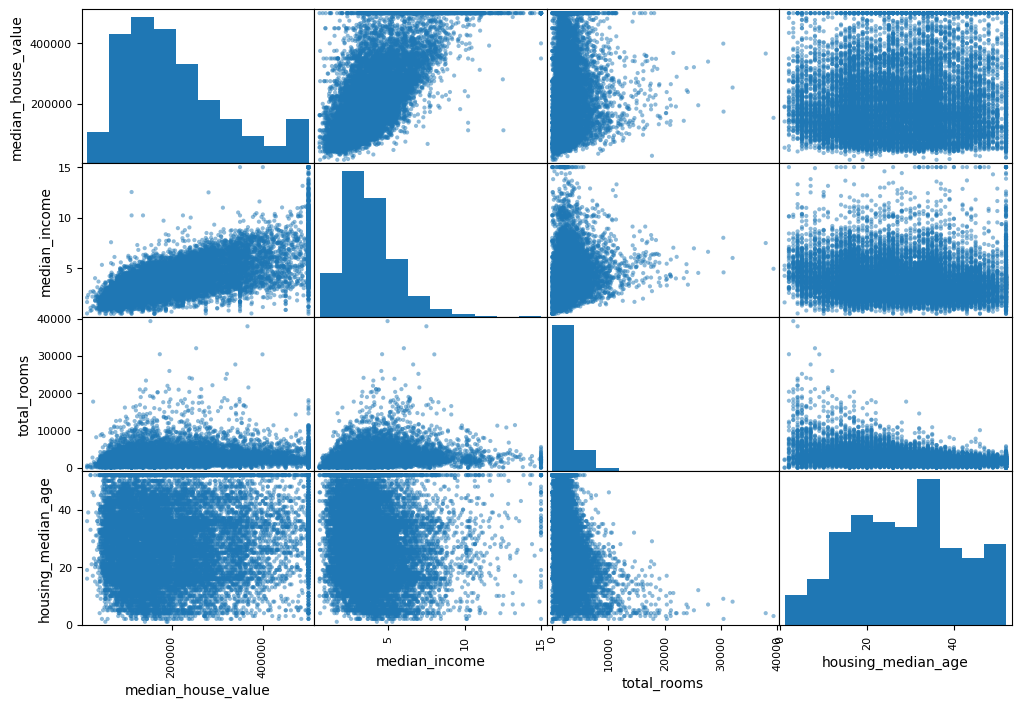

In [16]:
from pandas.plotting import scatter_matrix
attributes = ["median_house_value", "median_income", "total_rooms",
"housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
plt.show()

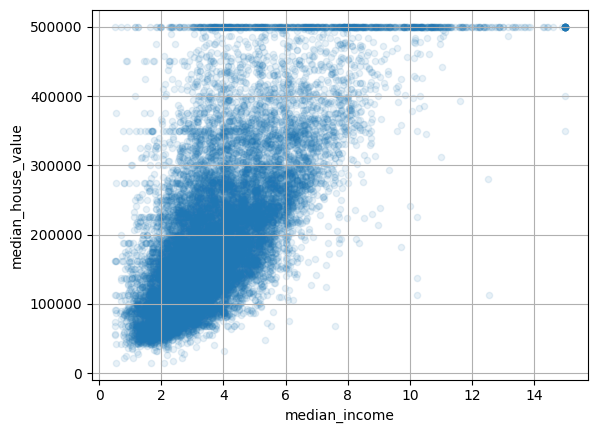

In [17]:
housing.plot(kind="scatter", x="median_income",
y="median_house_value",
alpha=0.1, grid=True)
plt.show()

## Feature eng

In [18]:
housing["rooms_per_house"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["people_per_house"] = housing["population"] / housing["households"]

In [19]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

# Cleaning

In [20]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")
housing_num = housing.select_dtypes(include=[np.number])

In [21]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [22]:
imputer.statistics_

array([-118.5  ,   34.26 ,   29.   , 2131.   ,  434.   , 1163.5  ,
        409.   ,    3.528])

In [23]:
X = imputer.transform(housing_num)

In [24]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
index=housing_num.index)

## Transformations

In [25]:
from sklearn.preprocessing import OneHotEncoder

In [26]:
cat_encoder = OneHotEncoder()
housing_cat = housing[['ocean_proximity']]
housing_cat_encoded = cat_encoder.fit_transform(housing_cat)

In [27]:
type(housing[['ocean_proximity']])

pandas.core.frame.DataFrame

In [28]:
housing_cat_encoded

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 16512 stored elements and shape (16512, 5)>

In [29]:
cat_encoder.feature_names_in_

array(['ocean_proximity'], dtype=object)

In [30]:
from sklearn.preprocessing import MinMaxScaler

In [31]:
min_max_scaler = MinMaxScaler(feature_range=(-1,1))
housing_min_max_scaled = min_max_scaler.fit_transform(housing_num)

In [32]:
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(housing_num)

In [33]:
housing_num_std_scaled

array([[ 0.69609501, -0.78161439, -0.20616709, ...,  6.49532393,
         3.4612737 , -0.81612105],
       [-1.19641721,  0.7686309 , -0.1268606 , ..., -0.11041638,
        -0.16072115,  0.61414908],
       [ 0.69110158, -0.71136159,  1.37996263, ...,  1.28544488,
         0.83070079, -0.46420416],
       ...,
       [ 0.15181049,  0.31901293, -1.7922968 , ...,  0.00894251,
         0.01376911,  0.11063723],
       [ 1.24537297, -1.27806757, -1.55437735, ..., -0.67349879,
        -0.70798607,  1.93976401],
       [-1.28629906,  0.83888371,  1.45926912, ..., -0.24890914,
        -0.08933877,  0.60458241]])

In [34]:
from sklearn.metrics.pairwise import rbf_kernel
age_simil_35 = rbf_kernel(housing[["housing_median_age"]], [[35]],
gamma=0.1)

In [35]:
from sklearn.pipeline import Pipeline
num_pipeline = Pipeline([
("impute", SimpleImputer(strategy="median")),
("standardize", StandardScaler()),
])

In [36]:
num_pipeline

Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                ('standardize', StandardScaler())])

In [37]:
housing_num_prepared = num_pipeline.fit_transform(housing_num)

In [38]:
df_housing_num_prepared = pd.DataFrame(
housing_num_prepared,
columns=num_pipeline.get_feature_names_out(),
index=housing_num.index)

In [39]:
df_housing_num_prepared

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
15052,0.696095,-0.781614,-0.206167,1.960298,3.226208,6.495324,3.461274,-0.816121
19091,-1.196417,0.768631,-0.126861,-0.095723,-0.319827,-0.110416,-0.160721,0.614149
7511,0.691102,-0.711362,1.379963,0.346036,0.683359,1.285445,0.830701,-0.464204
14609,0.741036,-0.711362,0.745511,0.001372,-0.250061,-0.125906,-0.173940,0.832343
18,-1.341227,1.030908,1.697189,-0.182234,-0.194729,-0.393780,-0.210953,-0.987690
...,...,...,...,...,...,...,...,...
13474,0.651154,-0.861234,0.745511,-0.547146,-0.502662,-0.402891,-0.475332,-0.273396
11382,0.661141,-0.814399,0.745511,-0.659887,-0.752857,-0.627942,-0.774081,-0.257417
15031,0.151810,0.319013,-1.792297,0.113192,-0.043169,0.008943,0.013769,0.110637
20509,1.245373,-1.278068,-1.554377,-0.500669,-0.764886,-0.673499,-0.707986,1.939764


In [40]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
num_attribs = ["longitude", "latitude", "housing_median_age",
"total_rooms",
"total_bedrooms", "population", "households",
"median_income"]
cat_attribs = ["ocean_proximity"]
cat_pipeline = make_pipeline(
SimpleImputer(strategy="most_frequent"),
OneHotEncoder(handle_unknown="ignore"))
preprocessing = ColumnTransformer([
("num", num_pipeline, num_attribs),
("cat", cat_pipeline, cat_attribs),
])

In [41]:
from sklearn.compose import make_column_selector,make_column_transformer
preprocessing = make_column_transformer(
(num_pipeline, make_column_selector(dtype_include=np.number)),
(cat_pipeline, make_column_selector(dtype_include=object)),
)

In [42]:
housing_prepared = preprocessing.fit_transform(housing) 

In [43]:
preprocessing.get_feature_names_out()

array(['pipeline-1__longitude', 'pipeline-1__latitude',
       'pipeline-1__housing_median_age', 'pipeline-1__total_rooms',
       'pipeline-1__total_bedrooms', 'pipeline-1__population',
       'pipeline-1__households', 'pipeline-1__median_income',
       'pipeline-2__ocean_proximity_<1H OCEAN',
       'pipeline-2__ocean_proximity_INLAND',
       'pipeline-2__ocean_proximity_ISLAND',
       'pipeline-2__ocean_proximity_NEAR BAY',
       'pipeline-2__ocean_proximity_NEAR OCEAN'], dtype=object)

In [44]:
pd.DataFrame(housing_prepared,columns=preprocessing.get_feature_names_out())

,pipeline-1__longitude,pipeline-1__latitude,pipeline-1__housing_median_age,pipeline-1__total_rooms,pipeline-1__total_bedrooms,pipeline-1__population,pipeline-1__households,pipeline-1__median_income,pipeline-2__ocean_proximity_<1H OCEAN,pipeline-2__ocean_proximity_INLAND,pipeline-2__ocean_proximity_ISLAND,pipeline-2__ocean_proximity_NEAR BAY,pipeline-2__ocean_proximity_NEAR OCEAN
0,0.696095,-0.781614,-0.206167,1.960298,3.226208,6.495324,3.461274,-0.816121,1.0,0.0,0.0,0.0,0.0
1,-1.196417,0.768631,-0.126861,-0.095723,-0.319827,-0.110416,-0.160721,0.614149,1.0,0.0,0.0,0.0,0.0
2,0.691102,-0.711362,1.379963,0.346036,0.683359,1.285445,0.830701,-0.464204,1.0,0.0,0.0,0.0,0.0
3,0.741036,-0.711362,0.745511,0.001372,-0.250061,-0.125906,-0.173940,0.832343,1.0,0.0,0.0,0.0,0.0
4,-1.341227,1.030908,1.697189,-0.182234,-0.194729,-0.393780,-0.210953,-0.987690,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16507,0.651154,-0.861234,0.745511,-0.547146,-0.502662,-0.402891,-0.475332,-0.273396,1.0,0.0,0.0,0.0,0.0
16508,0.661141,-0.814399,0.745511,-0.659887,-0.752857,-0.627942,-0.774081,-0.257417,1.0,0.0,0.0,0.0,0.0
16509,0.151810,0.319013,-1.792297,0.113192,-0.043169,0.008943,0.013769,0.110637,0.0,1.0,0.0,0.0,0.0
16510,1.245373,-1.278068,-1.554377,-0.500669,-0.764886,-0.673499,-0.707986,1.939764,1.0,0.0,0.0,0.0,0.0


In [45]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state
    def fit(self, X, y=None, sample_weight=None):
        self.kmeans_ = KMeans(self.n_clusters,
        random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)
        return self # always return self!
    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_,
                        gamma=self.gamma)
    def get_feature_names_out(self, names=None):
        return [f"Cluster {i} similarity" for i in
                range(self.n_clusters)]

In [46]:
from sklearn.pipeline import FunctionTransformer



def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]  # feature names out

def ratio_pipeline():
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio, feature_names_out=ratio_name),
        StandardScaler())

log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler())
cluster_simil = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)
default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                                     StandardScaler())
preprocessing = ColumnTransformer([
        ("bedrooms", ratio_pipeline(), ["total_bedrooms", "total_rooms"]),
        ("rooms_per_house", ratio_pipeline(), ["total_rooms", "households"]),
        ("people_per_house", ratio_pipeline(), ["population", "households"]),
        ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population",
                               "households", "median_income"]),
        ("geo", cluster_simil, ["latitude", "longitude"]),
        ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
    ],
    remainder=default_num_pipeline)  # one column remaining: housing_median_age

In [47]:
housing_prepared = preprocessing.fit_transform(housing)

In [48]:
preprocessing.get_feature_names_out()

array(['bedrooms__ratio', 'rooms_per_house__ratio',
       'people_per_house__ratio', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'geo__Cluster 0 similarity',
       'geo__Cluster 1 similarity', 'geo__Cluster 2 similarity',
       'geo__Cluster 3 similarity', 'geo__Cluster 4 similarity',
       'geo__Cluster 5 similarity', 'geo__Cluster 6 similarity',
       'geo__Cluster 7 similarity', 'geo__Cluster 8 similarity',
       'geo__Cluster 9 similarity', 'cat__ocean_proximity_<1H OCEAN',
       'cat__ocean_proximity_INLAND', 'cat__ocean_proximity_ISLAND',
       'cat__ocean_proximity_NEAR BAY', 'cat__ocean_proximity_NEAR OCEAN',
       'remainder__housing_median_age'], dtype=object)

# Model training

### Linear regression

In [49]:
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x74e...
                                                   'median_income']),
                                                 ('geo',
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x74eb45321010>)])),
                ('linearregression', LinearRegression())])

In [50]:
housing_predictions = lin_reg.predict(housing)

In [51]:
housing_predictions[:5].round(2)

array([126523.28, 293182.88, 203467.31, 304245.63, 198140.07])

In [52]:
housing_labels.iloc[:5].values

array([154500., 277300., 176900., 342700., 158700.])

In [53]:
# extra code – computes the error ratios
error_ratios = housing_predictions[:5].round(-2) / housing_labels.iloc[:5].values - 1
print(", ".join([f"{100 * ratio:.1f}%" for ratio in error_ratios]))

-18.1%, 5.7%, 15.0%, -11.2%, 24.8%


In [54]:
from sklearn.metrics import root_mean_squared_error

lin_rmse = root_mean_squared_error(housing_labels, housing_predictions,
                              )
lin_rmse

np.float64(69195.70945103816)

## Decision Tree Regressor

In [55]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name at 0x74e...
                                                  ClusterSimilarity(random_state=42),
                                                  ['latitude', 'longitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x74eb45321010>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

In [56]:
housing_predictions = tree_reg.predict(housing)
tree_rmse = root_mean_squared_error(housing_labels, housing_predictions,)
                              
tree_rmse

np.float64(0.0)

## Crossvalidation

In [57]:
from sklearn.model_selection import cross_val_score

tree_rmses = -cross_val_score(tree_reg, housing, housing_labels,
                              scoring="neg_root_mean_squared_error", cv=10)

In [59]:
tree_rmses

array([66770.42472319, 66763.08930465, 68291.86066522, 66845.66543673,
       67903.07221527, 68431.38517936, 63967.38753077, 66908.93509054,
       65599.35633423, 68653.91893155])

In [61]:
pd.Series(tree_rmses).describe()

count       10.000000
mean     67013.509541
std       1436.292071
min      63967.387531
25%      66764.923159
50%      66877.300264
75%      68194.663553
max      68653.918932
dtype: float64

In [62]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = make_pipeline(preprocessing,
                           RandomForestRegressor(random_state=42))
forest_rmses = -cross_val_score(forest_reg, housing, housing_labels,
                                scoring="neg_root_mean_squared_error", cv=10)

In [63]:
pd.Series(forest_rmses).describe()

count       10.000000
mean     47194.268215
std       1464.772304
min      44703.733369
25%      46745.257276
50%      47366.749347
75%      48135.660219
max      49030.003595
dtype: float64

In [64]:
forest_reg.fit(housing, housing_labels)
housing_predictions = forest_reg.predict(housing)
forest_rmse = root_mean_squared_error(housing_labels, housing_predictions,)
forest_rmse

np.float64(17606.075517973204)

## Finetuning

In [65]:
from sklearn.model_selection import GridSearchCV

full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestRegressor(random_state=42)),
])
param_grid = [
    {'preprocessing__geo__n_clusters': [5, 8, 10],
     'random_forest__max_features': [4, 6, 8]},
    {'preprocessing__geo__n_clusters': [10, 15],
     'random_forest__max_features': [6, 8, 10]},
]
grid_search = GridSearchCV(full_pipeline, param_grid, cv=3,
                           scoring='neg_root_mean_squared_error')
grid_search.fit(housing, housing_labels)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('bedrooms',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names_out=<f...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x74eb45321010>)])),
                                       ('random_forest',
                                        RandomForestRegressor(random_state=42))]),
             param_grid=[{'preprocessing__geo__n_clusters': [5, 8, 10],
                          'random_forest__max_features': [4, 6, 8]},
                         {'preprocessing__geo__n_clusters': [10, 15],
                          'random_forest__max_features': [6, 8, 10]}],
             scoring='neg_root_mean_squared_error')

In [66]:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False,
inplace=True)

In [68]:
cv_res.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessing__geo__n_clusters,param_random_forest__max_features,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
12,3.128731,0.005106,0.071955,0.002785,15,6,"{'preprocessing__geo__n_clusters': 15, 'random...",-44609.592364,-44594.003978,-44029.411743,-44411.002695,269.900587,1
13,4.043222,0.001557,0.069978,0.000726,15,8,"{'preprocessing__geo__n_clusters': 15, 'random...",-44512.275974,-44881.423229,-44749.006862,-44714.235355,152.696250,2
7,3.098815,0.021966,0.072079,0.003025,10,6,"{'preprocessing__geo__n_clusters': 10, 'random...",-44909.650571,-45748.960233,-44804.830316,-45154.480373,422.533272,3
9,3.093154,0.018942,0.071501,0.002770,10,6,"{'preprocessing__geo__n_clusters': 10, 'random...",-44909.650571,-45748.960233,-44804.830316,-45154.480373,422.533272,3
14,5.082950,0.055282,0.070140,0.000614,15,10,"{'preprocessing__geo__n_clusters': 15, 'random...",-44989.556455,-45737.217108,-44910.573067,-45212.448877,372.465539,5


In [69]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
param_distribs = {'preprocessing__geo__n_clusters': randint(low=3,
high=50),
'random_forest__max_features': randint(low=2,
high=20)}
rnd_search = RandomizedSearchCV(
full_pipeline, param_distributions=param_distribs, n_iter=10,
cv=3,
scoring='neg_root_mean_squared_error', random_state=42)
rnd_search.fit(housing, housing_labels)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('standardscaler',
                                                                                           StandardScaler())]),
                                                                transformers=[('bedrooms',
                                                                               Pipeline(steps=[('simpleimputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('functiontransformer',
                                                                                                FunctionTransformer(feature_names_...
                                             ('random_forest',
                                              RandomForestRegressor(random_state=42))]),
                   param_distributions={'preprocessing__geo__n_clusters': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x74ebf0288ce0>,
                                        'random_forest__max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x74eb46172360>},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [70]:
final_model = rnd_search.best_estimator_

In [76]:
feature_importances = final_model["random_forest"].feature_importances_

In [77]:
sorted(zip(feature_importances,final_model["preprocessing"].get_feature_names_out()),reverse=True)

[(np.float64(0.18233618609586028), 'log__median_income'),
 (np.float64(0.07731194202786229), 'cat__ocean_proximity_INLAND'),
 (np.float64(0.07357361401433173), 'bedrooms__ratio'),
 (np.float64(0.05860131725475182), 'rooms_per_house__ratio'),
 (np.float64(0.05064926369762589), 'people_per_house__ratio'),
 (np.float64(0.035274984735557346), 'geo__Cluster 33 similarity'),
 (np.float64(0.027363725268702947), 'geo__Cluster 28 similarity'),
 (np.float64(0.023829923938986076), 'geo__Cluster 15 similarity'),
 (np.float64(0.02181838595905117), 'geo__Cluster 12 similarity'),
 (np.float64(0.02140912058947828), 'geo__Cluster 2 similarity'),
 (np.float64(0.020654826578794343), 'geo__Cluster 32 similarity'),
 (np.float64(0.02012958855257257), 'geo__Cluster 44 similarity'),
 (np.float64(0.01547578848510949), 'geo__Cluster 26 similarity'),
 (np.float64(0.014288755915746442), 'geo__Cluster 31 similarity'),
 (np.float64(0.01344345171021989), 'geo__Cluster 20 similarity'),
 (np.float64(0.0133557592562795

In [78]:
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()
final_predictions = final_model.predict(X_test)
final_rmse = root_mean_squared_error(y_test, final_predictions)
print(final_rmse)

41075.45124841359


In [79]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([38679.77527656, 43338.90140597])

In [80]:
import joblib

joblib.dump(final_model, "my_california_housing_model.pkl")

['my_california_housing_model.pkl']